# *lsforce* example script: 2016 Lamplugh rock avalanche
---

This example notebook uses *lsforce* to invert for the force-time function of the 28 June 2016 Lamplugh rock avalanche in Glacier Bay National Park, Alaska (Bessette-Kirton et al., 2018; Dufresne et al., 2019). The notebook walks through data collection and creation of all three major *lsforce* objects: `LSData`, `LSForce`, and `LSTrajectory`. The latter two objects are created twice, once each for the "full" parameterization method (`method='full'`) and the "triangle" parameterization method (`method='triangle'`).

**References**

<p>
<div style="text-indent:-36px; padding-left:36px;">
<p>
Bessette-Kirton, E. K., Coe, J. A., & Zhou, W. (2018). Using stereo satellite imagery to account for ablation, entrainment, and compaction in volume calculations for rock avalanches on glaciers: application to the 2016 Lamplugh rock avalanche in Glacier Bay National Park, Alaska. <em>Journal of Geophysical Research: Earth Surface, 123</em>(4), 622–641. <a href="https://doi.org/10.1002/2017JF004512">https://doi.org/10.1002/2017JF004512</a>
</p>
<p>
Dufresne, A., Wolken, G. J., Hibert, C., Bessette-Kirton, E. K., Coe, J. A., Geertsema, M., & Ekström, G. (2019). The 2016 Lamplugh rock avalanche, Alaska: deposit structures and emplacement dynamics. <em>Landslides, 16</em>(12), 2301–2319. <a href="https://doi.org/10.1007/s10346-019-01225-4">https://doi.org/10.1007/s10346-019-01225-4</a>
</p>
</div>

### Import necessary modules

In [1]:
from pathlib import Path

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth

from lsforce import LSData, LSForce, LSTrajectory

# Ignore benign Matplotlib backend warning due to fig.show()
import warnings
warnings.filterwarnings(action='ignore', message='Matplotlib is currently using module')

### Define some constants, set up folder structure

In [2]:
PERIOD_RANGE = (10, 200)  # [s] Bandpass filter corners

LS_LAT, LS_LON = (58.7371, -136.8943)  # Guesstimate from Google Earth + lamplugh.tif
ORIGIN_TIME = UTCDateTime(2016, 6, 28, 16, 21, 3)

STARTTIME = ORIGIN_TIME - 150
ENDTIME = UTCDateTime(2016, 6, 28, 16, 26, 6) + 150

# Set up folder structure
main_folder = Path.cwd() / 'lamplugh'
if not main_folder.exists():
    main_folder.mkdir()

### Gather inversion waveforms
We have already prescreened these data that we use here, the user will likely want to spend some time choosing appropriate stations based on source to station distances and noise levels prior to creating the LSData object. Regardless of how the user gathers the waveforms they wish to use for the inversion, note that unless station correction is done beforehand, the station response information and station coordinates MUST be attached to each trace as demonstrated below.

AK.JIS..BHE -> AK.JIS..BHE
{'azimuth': 90.0, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 1 / 30150 (0.00332%)
Max absolute difference: 2.2737367544323206e-13
Max relative difference: 6.816769371198461e-14
 x: array([  974.,   980.,  1016., ...,   906.,   935.,  1017.])
 y: array([ 974,  980, 1016, ...,  906,  935, 1017], dtype=int32)

AK.JIS..BHZ -> AK.JIS..BHZ
{'azimuth': 0.0, 'dip': -90.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 73 / 30150 (0.242%)
Max absolute difference: 2.2737367544323206e-13
Max relative difference: 5.5067062021407764e-14
 x: array([-148., -131., -144., ...,  -20.,  -82., -103.])
 y: array([-148, -131, -144, ...,  -20,  -82, -103], dtype=int32)

AK.PNL..BHE -> AK.PNL..BHE
{'azimuth': 90.0, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 11 / 30150 (0.0365%)
Max absolute difference: 2.2737367544323206e-13
Max relative difference: 3.164135620181696e-14
 x: array([-1169., -1160., -1165.

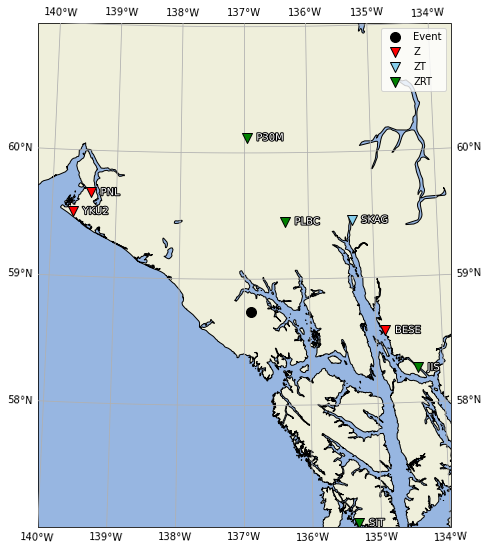

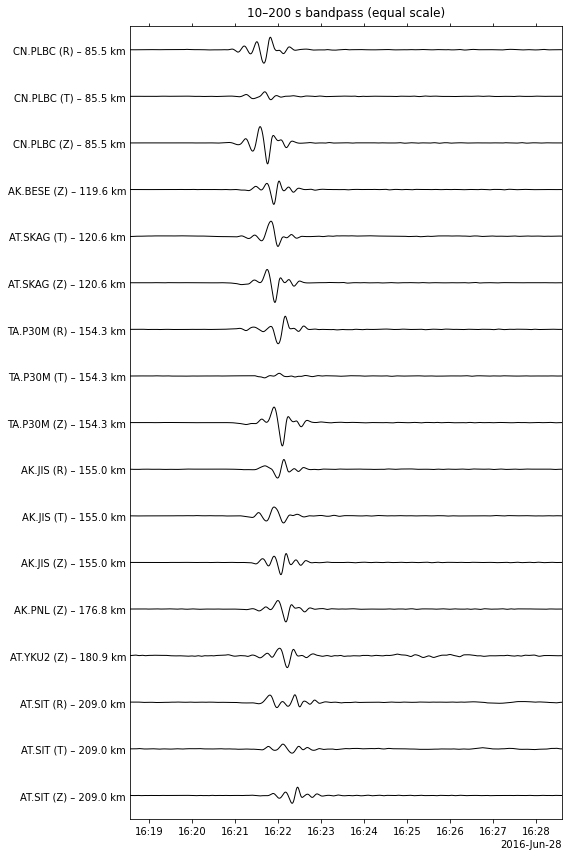

In [3]:
data_filename = main_folder / 'data.pkl'

# Download data if it doesn't exist as a file
if not data_filename.exists():

    client = Client('IRIS')
    waveform_kwargs = dict(
        location='', starttime=STARTTIME, endtime=ENDTIME, attach_response=True
    )

    # Gather waveforms
    NETWORKS = ('AK', 'AT', 'CN', 'TA')
    STATIONS = ('SKAG', 'BESE', 'P30M', 'JIS', 'PNL', 'YKU2', 'PLBC', 'SIT')
    st = client.get_waveforms(
        network=','.join(NETWORKS),
        station=','.join(STATIONS),
        channel='BH?,HH?',
        **waveform_kwargs,
    )

    # Grab coordinates
    inv = client.get_stations(
        network=','.join(NETWORKS),
        starttime=STARTTIME,
        endtime=ENDTIME,
        level='channel',
    )

    # Assign coordinates to Traces
    for tr in st:
        coords = inv.get_coordinates(tr.id, datetime=STARTTIME)
        tr.stats.latitude = coords['latitude']
        tr.stats.longitude = coords['longitude']

    st.write(str(data_filename), format='PICKLE')

# Use file if it exists, for speed
else:
    st = read(str(data_filename), format='PICKLE')

# Create LSData object
data = LSData(st, source_lat=LS_LAT, source_lon=LS_LON)

# Remove some noisy horizontals
for station in 'BESE', 'PNL', 'YKU2':
    for tr in data.st_proc.select(station=station, component='[RT]'):
        data.st_proc.remove(tr)
for tr in data.st_proc.select(station='SKAG', component='R'):
    data.st_proc.remove(tr)

# Create plots
data.plot_stations(label_stations=True, gshhs_scale='h');
data.plot_data(period_range=PERIOD_RANGE);

### Gather reference waveform
This is an optional step that allows the user to plot a high frequency reference waveform alongside the force-time function for reference. Here we apply a time correction to approximately adjust the trace for travel time so it aligns roughly with the force-time function.

In [4]:
SEISMIC_VELO = 2.5  # [km/s] For travel time removal

KM_PER_M = 1 / 1000  # [km/m]

client = Client('IRIS')

# Gather a single trace
tr_hf = client.get_waveforms(
    network='CN',
    station='PLBC',
    location='',
    channel='HHZ',
    starttime=STARTTIME,
    endtime=ENDTIME,
    attach_response=True,
)[0]

# Processing
tr_hf.remove_response()
tr_hf.detrend('demean')
tr_hf.taper(max_percentage=0.05)
tr_hf.filter('bandpass', freqmin=1, freqmax=5)

# Add "distance" to tr.stats
ref_inv = client.get_stations(
    network=tr_hf.stats.network,
    station=tr_hf.stats.station,
    starttime=STARTTIME,
    endtime=ENDTIME,
    level='channel',
)
coords = ref_inv.get_coordinates(tr_hf.id, datetime=STARTTIME)
tr_hf.stats.latitude = coords['latitude']
tr_hf.stats.longitude = coords['longitude']
dist = gps2dist_azimuth(LS_LAT, LS_LON, tr_hf.stats.latitude, tr_hf.stats.longitude)[0]  # [m]
tr_hf.stats.distance = dist * KM_PER_M  # [km]

# Approximate correction for travel time
hf_shift = tr_hf.stats.distance / SEISMIC_VELO

### Setup both full and triangle parameterization methods

In [5]:
INIT_KWARGS = dict(data=data, data_sampling_rate=1, main_folder=main_folder)

force_full = LSForce(**INIT_KWARGS)
force_triangle = LSForce(method='triangle', **INIT_KWARGS)

SETUP_KWARGS = dict(
    period_range=PERIOD_RANGE,
    zerophase=True,
    syngine_model='iasp91_2s',
    weights='prenoise',
    noise_window_dur=150,
)

force_full.setup(**SETUP_KWARGS)
force_triangle.setup(**SETUP_KWARGS, triangle_half_width=5)

Getting Green's functions...
Found BESE (1/8)
Found JIS (2/8)
Found P30M (3/8)
Found PLBC (4/8)
Found PNL (5/8)
Found SIT (6/8)
Found SKAG (7/8)
Found YKU2 (8/8)
Getting Green's functions...
Found BESE (1/8)
Found JIS (2/8)
Found P30M (3/8)
Found PLBC (4/8)
Found PNL (5/8)
Found SIT (6/8)
Found SKAG (7/8)
Found YKU2 (8/8)


### Invert both

In [ ]:
INVERT_KWARGS = dict(
    zero_time=132,
    impose_zero_start=True,
    add_to_zero=True,
    jackknife=True,
    num_iter=20,
    frac_delete=0.25,
    zero_scaler=20,
)

force_full.invert(tikhonov_ratios=(0.4, 0, 0.6), alpha=2.3e-17, **INVERT_KWARGS)
force_triangle.invert(tikhonov_ratios=(0, 0, 1), alpha=1.9e-17, **INVERT_KWARGS)

Variance reduction = 86.924736 percent
Starting jackknife iterations


### Plot inversion results
We first plot the full inversion results, with the individual jackknife solutions computed from subsets of the dataset shown as semi-transparent lines and the best solution in bold color for each component. This is compared along-side the high frequency waveform that we downloaded for reference.

In [ ]:
XLIM = (-20, 150)  # [s] x-axis (time) limits for plots
force_full.plot_forces(highf_tr=tr_hf, hfshift=hf_shift, jackshowall=True, xlim=XLIM);

Next we create another type of plot that shows the full solution with the range of jackknife solutions shown as shaded areas around the bold best solution for each component, the amplitude of forces over time, and the horizontal azimuth and vertical slope angle at each time.

In [ ]:
force_full.plot_angle_magnitude(xlim=XLIM);

Finally, we look at how well the data produced by this best-fitting model reproduces the observed data. This plot also reports the variance reduction, which in this case is 87%, a typical value for a good solution. We also are reassured by seeing that the modeled data is not fitting noise (e.g., on channel TA.P30M) while still doing a reasonable job at fitting the data on all channels.

In [ ]:
force_full.plot_fits(xlim=(-50, 200), equal_scale=False);

The same built-in plots are available for the triangle parameterization. Comparing the plots for the triangle method (below) to the full method (above), we see that the two solutions is similar in overall shape and amplitude, but with lower time resolution and less detail for the triangle method. The data is fit nearly as well with this simpler solution (85% variance reduction).

In [ ]:
force_triangle.plot_forces(highf_tr=tr_hf, hfshift=hf_shift, jackshowall=True, xlim=XLIM);
#force_triangle.plot_angle_magnitude(xlim=XLIM);
force_triangle.plot_fits(xlim=(-50, 200), equal_scale=False);

### Compute trajectories
To estimate the trajectory of the center of mass, we set a estimated total runout distance to 4 km horizontally. An alternative option, not shown here, is the user can instead set the mass (assumed constant) and not set the runout distance.

We set the total duration of double integration to 320 s even though the long-period forces are near zero by t=~100 s because, as suggested by Dufresne et al. (2019), based on the duration of the high-frequency seismic signal and field evidence, the flow likely continued to glide over the glacier for a longer time period just without major decelerations that would be resolvable with long-period single force inversions. We also use the duration of 320 s to apply a linear detrend to the velocity such that the velocity must equal zero by that time. We further reduce noise in the trajectory by setting the acceleration to zero after 90 s because the force signal is indistinguishable from zero after that point for both solutions.

In [ ]:
L = 4  # [km] Estimate of horizontal COM runout length
DURATION = 320  # [s] Duration to use for trajectory integration
ZERO_ACC = 90.  # [s] Duration after which accelerations are set to zero

TRAJECTORY_KWARGS = dict(target_length=L, duration=DURATION, detrend_velocity=DURATION, mass=None, zeroacc=ZERO_ACC)
trajectory_full = LSTrajectory(force_full, **TRAJECTORY_KWARGS)
trajectory_triangle = LSTrajectory(force_triangle, **TRAJECTORY_KWARGS)

### Plot trajectories
Since we set the mass to None when computing the trajectories, the codes will report the mass that would give that trajectory distance. However, this mass may not be very accurate because it's based on the assumption of a constant mass. For example, here the mass found is ~30 billion kg, much less than the 141 billion kg estimated by Dufresne et al. (2019). It could be that we are overestimating the travel distance of the center of mass, but there also could be more complex event dynamics at play (e.g., our inversion suggests a two-part failure initiation) and/or we could be seeing the effects of the amplitude reduction caused by regularization of our solution.

In [ ]:
# Plot trajectories for the full inversion
trajectory_full.plot_trajectory(plot_jackknife=True);  # Horizontal trajectory
trajectory_full.plot_trajectory(plot_jackknife=True, elevation_profile=True);  # Vertical trajectory

In [ ]:
# Plot trajectories for the triangle inversion
trajectory_triangle.plot_trajectory(plot_jackknife=True);  # Horizontal trajectory
trajectory_triangle.plot_trajectory(plot_jackknife=True, elevation_profile=True);  # Vertical trajectory